# Exploring Mental Health Discourse on Reddit (Tokenization, Normalization, and Descriptive Statistics)

This notebook explores textual data extracted from Reddit posts related to mental health. It focuses on preprocessing techniques such as tokenization and normalization to prepare the text for analysis. The goal is to gain a deeper understanding of how mental health topics are discussed on Reddit through comprehensive text analysis.

### Import Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random
from spellchecker import SpellChecker

import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# import data 
df = pd.read_csv('data/reddit_posts.csv')
mental_health_support_df = pd.read_csv('data/mental_health_support_posts.csv')
mental_health_df = pd.read_csv('data/mental_health_posts.csv')

In [4]:
df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490


In [5]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490


In [6]:
mental_health_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,My daughter is scaring me tonight. No idea how...,922,0.98,2023-12-09 02:50:29,My daughter (10) very suddenly this evening sa...,mentalhealth,ajgl1990,False,/r/mentalhealth/comments/18e3pnh/my_daughter_i...,246,940.816327,18.816327,0.002006
1,Brain cancer at 16… I’m a mess now.,829,0.98,2023-11-10 22:18:46,Became extremely I’ll at 16 and told my mom “t...,mentalhealth,Intelligent_Pipe7980,False,/r/mentalhealth/comments/17sfgi8/brain_cancer_...,88,845.918367,16.918367,0.001803
2,I did it. I graduated. I didn’t let depression...,825,0.99,2023-06-14 15:15:05,Depression took over but I won.,mentalhealth,No_Panic2551,False,/r/mentalhealth/comments/149ah8y/i_did_it_i_gr...,137,833.333333,8.333333,0.001777
3,Date raped and now pregnant and I’m just so sad,725,0.94,2023-11-25 04:06:49,I’ve never been to therapy despite a bunch of ...,mentalhealth,Sensitive_World7780,False,/r/mentalhealth/comments/183b3u5/date_raped_an...,61,771.276596,46.276596,0.001644
4,I killed myself on Monday and feel like I will...,662,0.97,2023-07-02 12:58:41,"I think the title says enough, on Monday I lit...",mentalhealth,Dry_Opportunity8703,False,/r/mentalhealth/comments/14onpo2/i_killed_myse...,127,682.474227,20.474227,0.001455


### Text Preprocessing (Tokenization and Normalization)

In [7]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [8]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [9]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

# output statistics for combined df 
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   3944.000000  3944.000000  3944.000000          3944.000000
mean      17.514452    31.669105     1.504298             0.000095
std       43.319617    75.437728     4.786048             0.000169
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000017
50%        2.000000     2.000000     0.000000             0.000043
75%       13.000000    30.154639     0.813953             0.000109
max      616.000000   940.816327    61.487179             0.003447

Token Count Statistics:
 count     3946
unique    3761
top         []
freq        10
Name: tokens, dtype: object

Most Common Words:
 [('like', 6343), ('feel', 5851), ('know', 3952), ('time', 3279), ('get', 3218), ('want', 3179), ('life', 2952), ('even', 2785), ('thing', 2685), ('really', 2541)]


Based on the descriptive statistics provided, we have opted to analyze each subreddit separately for r/MentalHealth and r/MentalHealthSupport. This approach allows for a more focused exploration of each subreddit's unique trends and characteristics. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return ""
    # Remove newline characters and excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens into a single string
    cleaned_text = ' '.join(tokens)
    # Remove spaces before punctuation
    cleaned_text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', cleaned_text)
    # Remove trailing punctuation
    cleaned_text = re.sub(r'([?.!"](?:\s|$))', r'\1', cleaned_text)
    return cleaned_text

def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

In [11]:
mental_health_support_df

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,158,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,159.595960,1.595960,0.003447
1,What changes your negative thoughts/ has made ...,43,0.98,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,43.877551,0.877551,0.000948
2,what is the point of living?,44,0.92,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,47.826087,3.826087,0.001033
3,I need a hug,22,0.9,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,24.444444,2.444444,0.000528
4,What are you like after a hug,22,0.97,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,22.680412,0.680412,0.000490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,Why am I so scared of everything?,15,1.0,2024-05-12 16:14:19,"I, (21 F) just finished my college this month ...",MentalHealthSupport,TerribleFish6588,False,/r/MentalHealthSupport/comments/1cqbf7x/why_am...,22.0,15.000000,0.000000,0.000324
1916,Hidden from my family,1,1.0,2024-05-12 10:47:20,My mom hid my existence from my entire extende...,MentalHealthSupport,Business_Berry6374,False,/r/MentalHealthSupport/comments/1cq54bk/hidden...,0.0,1.000000,0.000000,0.000022
1917,Has cbt helped anyone overcome negative though...,6,1.0,2024-05-12 09:26:35,"For years I’ve had negative ways of thinking, ...",MentalHealthSupport,soulliving3,False,/r/MentalHealthSupport/comments/1cq3z3q/has_cb...,4.0,6.000000,0.000000,0.000130
1918,Cognitive Dissonance,4,1.0,2024-05-12 08:44:40,\nSo after a huge blow out my bf has agreed to...,MentalHealthSupport,Crybabycalzone,False,/r/MentalHealthSupport/comments/1cq3dyp/cognit...,3.0,4.000000,0.000000,0.000086


In [12]:
# define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# enhanced preprocess function
spell = SpellChecker()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text).strip()  
    text = text.lower()  
    tokens = word_tokenize(text)  
    corrected_tokens = [spell.correction(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    cleaned_text = ' '.join(tokens)  
    cleaned_text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', cleaned_text) 
    cleaned_text = re.sub(r'([?.!"](?:\s|$))', r'\1', cleaned_text)  
    return cleaned_text

# apply pre-processing to original 'selftext' column
mental_health_df['selftext'] = mental_health_df['selftext'].astype(str).apply(preprocess_text)
mental_health_support_df['selftext'] = mental_health_support_df['selftext'].astype(str).apply(preprocess_text)

# tokenization and stop word removal
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

# convert 'selftext' to string to avoid float issues
mental_health_support_df['selftext'] = mental_health_support_df['selftext'].astype(str)
mental_health_df['selftext'] = mental_health_df['selftext'].astype(str)

# apply tokenization and stop word removal in parallel
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(
    delayed(tokenize_and_remove_stopwords)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(
    delayed(tokenize_and_remove_stopwords)(text) for text in mental_health_df['selftext'])

# apply enhanced preprocessing for cleaned text in parallel
mental_health_support_df['selftext'] = Parallel(n_jobs=-1)(
    delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['selftext'] = Parallel(n_jobs=-1)(
    delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    return sentiment_stats, sentiment_category_counts

# function to generate word cloud
def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

# time series plot function
def plot_time_series(subreddit_df, title):
    subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

## Descriptive Statistics 

### r/MentalHealthSupport subreddit

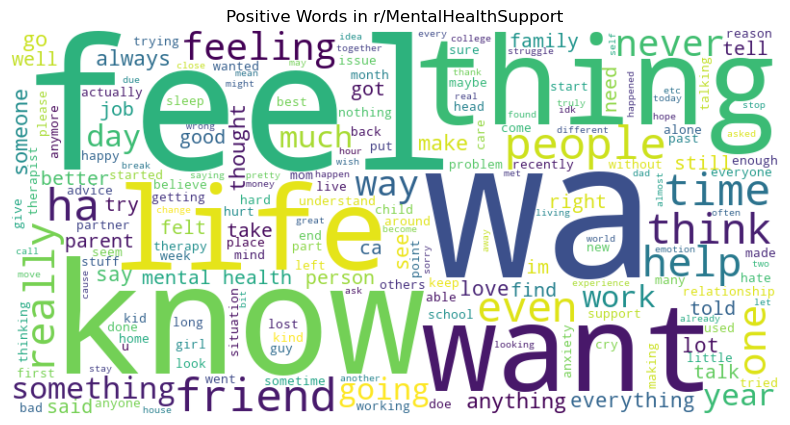

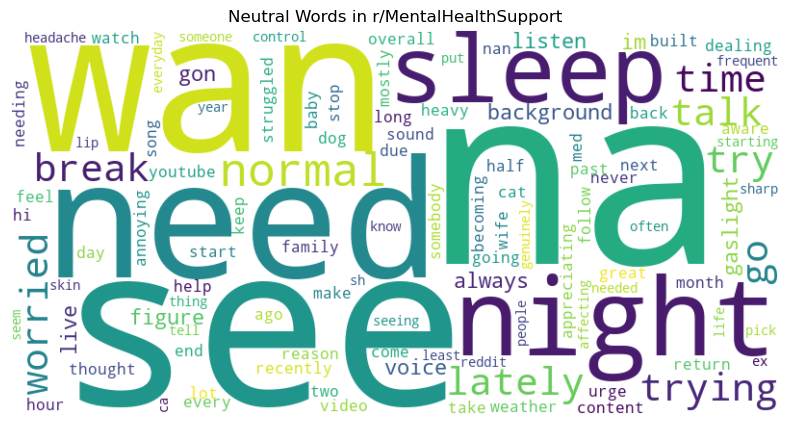

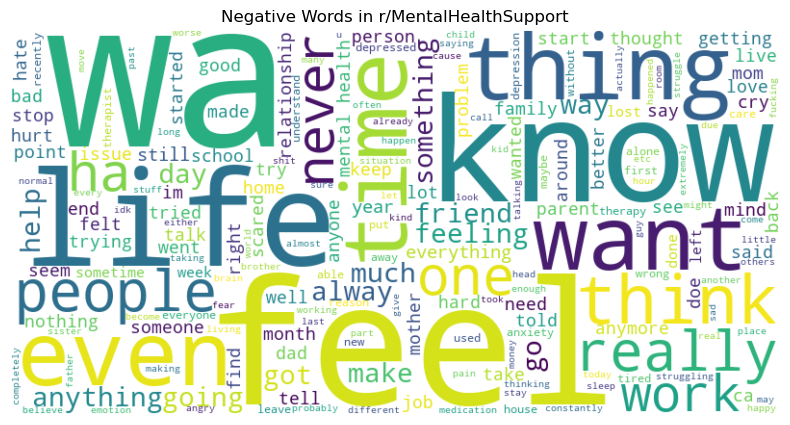

/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_87854/1489034072.py:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


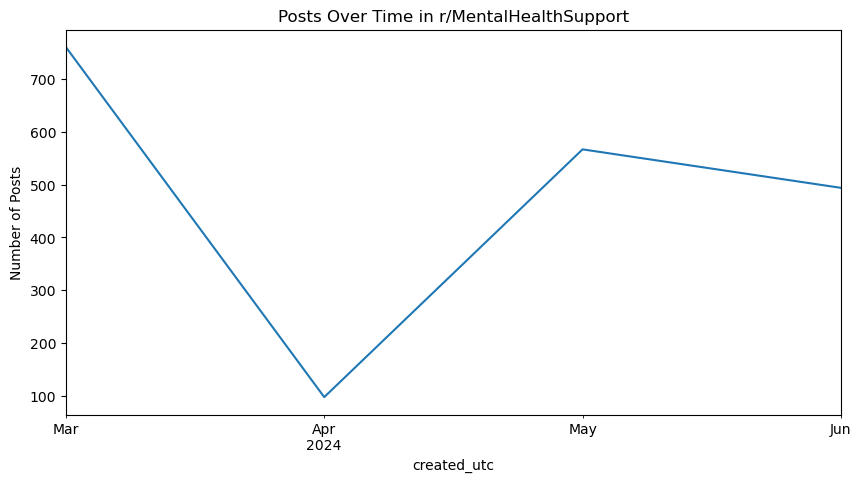


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   1918.000000  1918.000000  1918.000000          1918.000000
mean       2.164234     2.942524     0.127612             0.000064
std        5.404613     4.884876     0.356346             0.000106
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000022
50%        0.000000     2.000000     0.000000             0.000043
75%        2.000000     3.000000     0.000000             0.000065
max      154.000000   159.595960     3.826087             0.003447

Token Count Statistics:
 count    1920.000000
mean      116.476042
std       119.102434
min         0.000000
25%        43.000000
50%        82.000000
75%       145.250000
max      1219.000000
Name: tokens, dtype: float64

Most Common Words:
 [('wa', 4106), ('like', 3613), ('feel', 3317), ('know', 2265), ('time', 1890), 

In [13]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
mental_health_support_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

In [14]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['dream', 'laughed', 'something', 'see', 'mother', 'available', 'turned', 'please', 'capable', 'time', 'erratic', 'close', 'wonderful', 'like', 'feeling', 'caused', 'recommend', 'accident', 'try', 'tried']

Sampled Neutral Words:
['gaslight', 'skin', 'figure', 'trying', 'never', 'watch', 'video', 'sh', 'put', 'wife', 'see', 'make', 'cat', 'take', 'see', 'night', 'needing', 'sharp', 'lip', 'starting']

Sampled Negative Words:
['graphic', 'getting', 'nursing', 'need', 'would', 'control', 'innocent', 'harming', 'know', 'yet', 'got', 'least', 'behavior', 'back', 'messy', 'anything', 'like', 'anything', 'god', 'call']


### r/MentalHealth subreddit

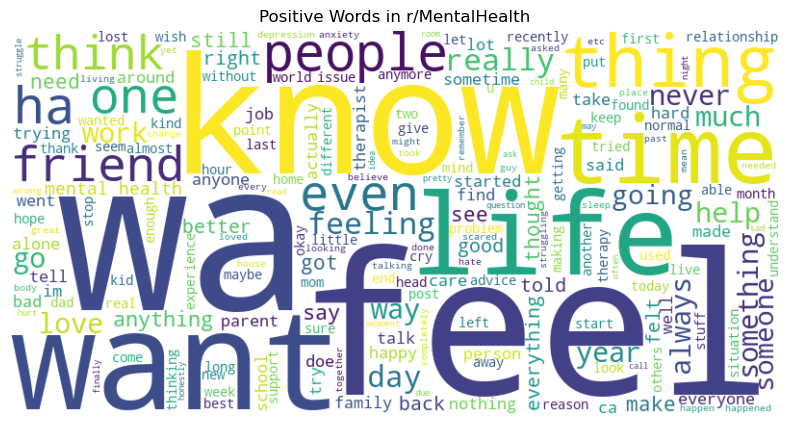

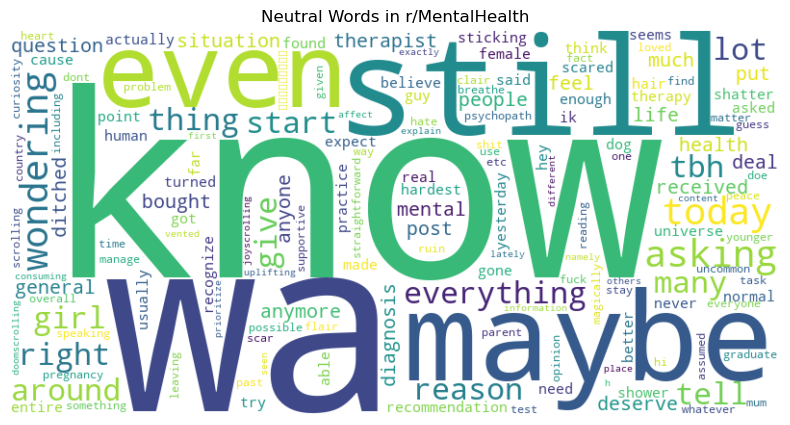

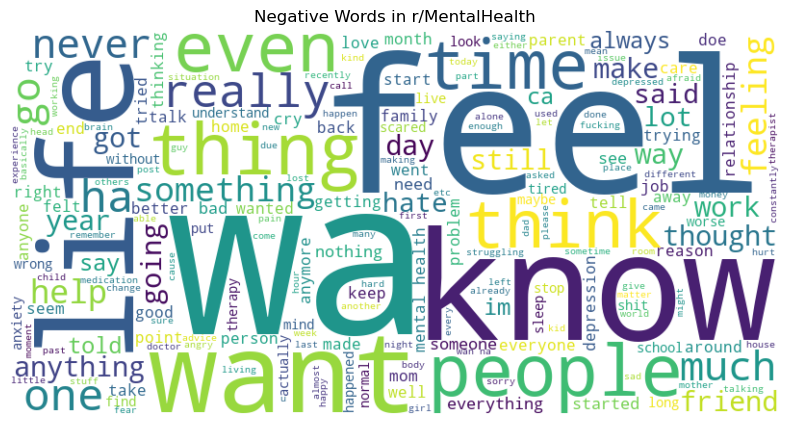

/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_87854/1489034072.py:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


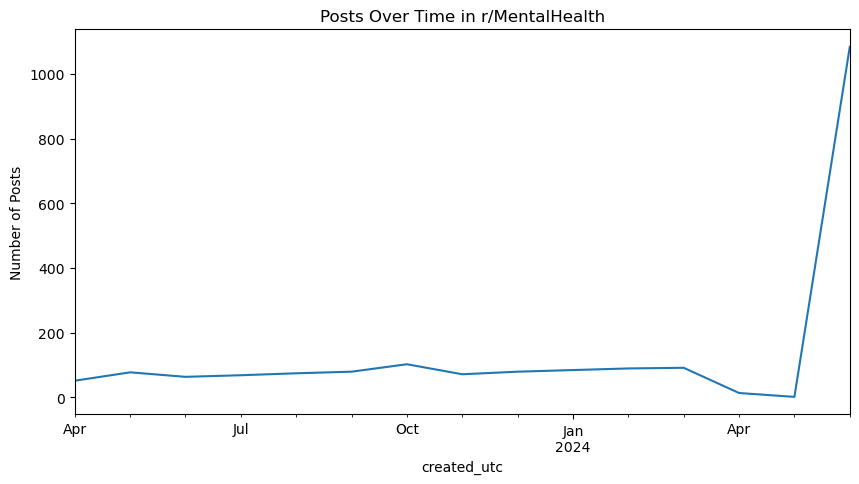


Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  2026.000000   2026.000000   2026.000000  2026.000000  2026.000000   
mean     56.056762      0.952567     32.046397    58.864358     2.807596   
std      93.746020      0.093561     56.496973    97.656802     6.402140   
min       0.000000      0.280000      0.000000     0.000000     0.000000   
25%       1.000000      0.950000      1.000000     1.000000     0.000000   
50%      13.000000      0.990000      8.000000    13.414894     0.469697   
75%      70.000000      1.000000     42.000000    73.747947     2.625905   
max     922.000000      1.000000    616.000000   940.816327    61.487179   

       upvotes/subscribers  
count          2026.000000  
mean              0.000125  
std               0.000208  
min               0.000000  
25%               0.000002  
50%               0.000029  
75%               0.000157  
max             

In [15]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
mental_health_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

In [16]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['location', 'life', 'happy', 'like', 'life', 'procedure', 'good', 'pedal', 'time', 'told', 'thought', 'thing', 'secret', 'probably', 'evaluated', 'sort', 'lonely', 'old', 'fantasizing', 'feel']

Sampled Neutral Words:
['wondering', 'feel', 'turned', 'right', 'know', 'normal', 'magically', 'ruin', 'straightforward', 'enough', 'bought', 'need', 'hate', 'hardest', 'much', 'anymore', 'consuming', 'everything', 'vented', 'seems']

Sampled Negative Words:
['wo', 'wife', 'young', 'anticipate', 'seeing', 'student', 'safe', 'worse', 'could', 'job', 'anything', 'arrest', 'cptsd', 'went', 'little', 'came', 'heap', 'took', 'somebody', 'dog']


### combined subreddits (r/MentalHealthSupport  and r/MentalHealth)

In [17]:
# combine both df into one
mental_health_support_df.reset_index(inplace=True)
mental_health_df.reset_index(inplace=True)

df = pd.concat([mental_health_support_df, 
                mental_health_df], 
               ignore_index=True)

# save processed dataframes to CSV files
df.to_csv('data/reddit_posts_cleaned.csv', index=False)
mental_health_support_df.to_csv('data/mental_health_support_posts_cleaned.csv', index=False)
mental_health_df.to_csv('data/mental_health_posts_cleaned.csv', index=False)

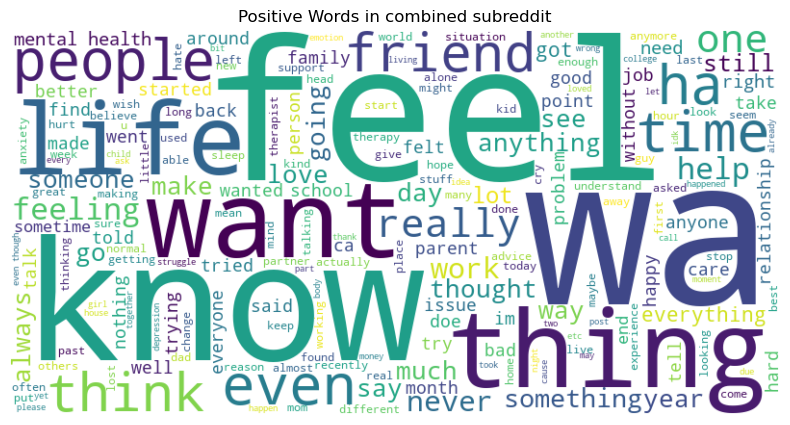

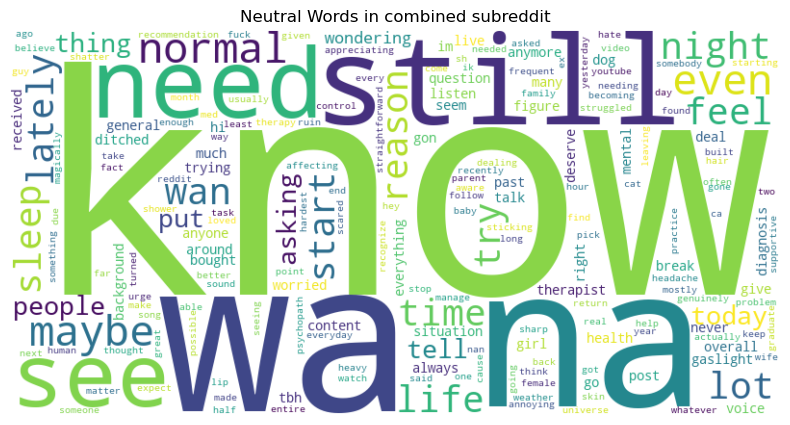

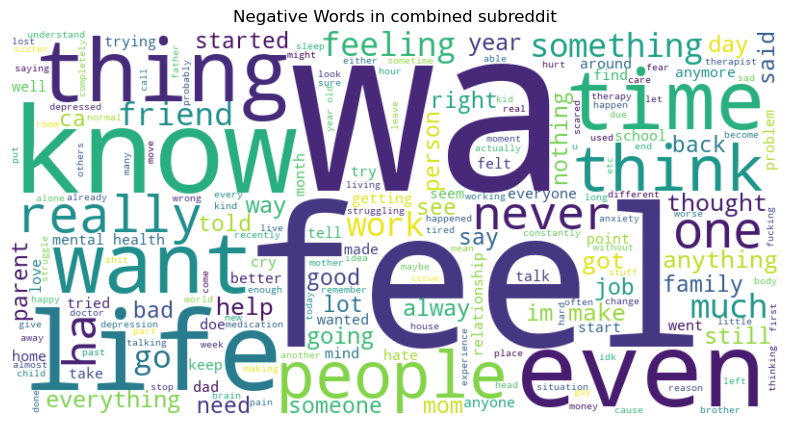

/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_87854/1489034072.py:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


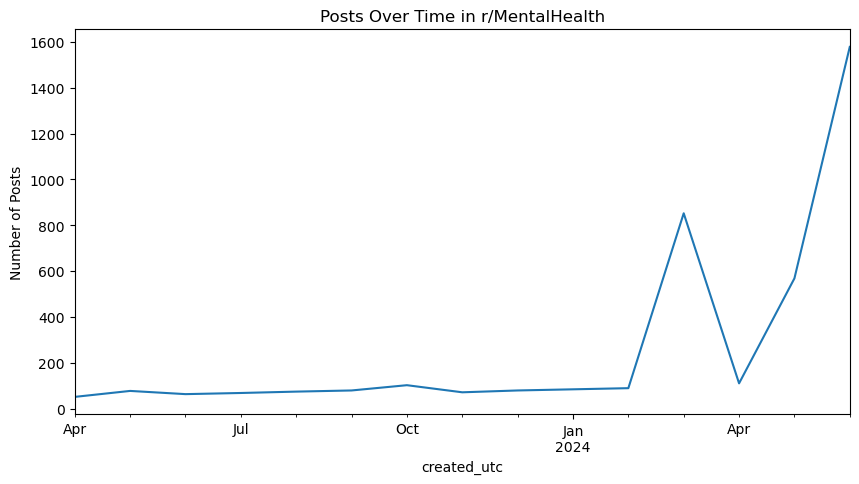


Descriptive Statistics for combined subreddit:
Numerical Statistics:
                          created_utc        index  num_comments      upvotes  \
count                           3945  3946.000000   3944.000000  3944.000000   
mean   2024-03-25 16:19:38.744486656   986.711860     17.514452    31.669105   
min              2023-04-06 07:17:59     0.000000      0.000000     0.000000   
25%              2024-03-06 02:48:20   493.000000      0.000000     1.000000   
50%              2024-05-18 17:43:26   986.000000      2.000000     2.000000   
75%              2024-06-13 18:59:14  1479.000000     13.000000    30.154639   
max              2024-06-17 04:45:52  2025.000000    616.000000   940.816327   
std                              NaN   570.859508     43.319617    75.437728   

         downvotes  upvotes/subscribers  
count  3944.000000          3944.000000  
mean      1.504298             0.000095  
min       0.000000             0.000000  
25%       0.000000             0.000017 

In [18]:
# combined subreddit
df_numerical_stats, df_token_count_stats, df_common_words = analyze_subreddit(df)
df_sentiment_stats, df_sentiment_category_counts = analyze_sentiments(df)
df_topics = topic_modeling(df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'],df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in combined subreddit")
generate_word_cloud(neutral_words, "Neutral Words in combined subreddit")
generate_word_cloud(negative_words, "Negative Words in combined subreddit")

# time series analysis for combined subreddit
plot_time_series(df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for combined subreddit:")
print("Numerical Statistics:\n", df_numerical_stats)
print("\nToken Count Statistics:\n", df_token_count_stats)
print("\nMost Common Words:\n", df_common_words)
print("\nSentiment Statistics:\n", df_sentiment_stats)
print("\nSentiment Category Counts:\n", df_sentiment_category_counts)

In [19]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['buzz', 'watching', 'broken', 'wa', 'companionship', 'pretty', 'think', 'got', 'like', 'see', 'wanted', 'informed', 'start', 'life', 'two', 'best', 'come', 'give', 'becomes', 'wa']

Sampled Neutral Words:
['know', 'deal', 'time', 'wa', 'pick', 'voice', 'asking', 'reading', 'know', 'manage', 'feel', 'bought', 'think', 'wa', 'everything', 'post', 'night', 'get', 'scared', 'annoying']

Sampled Negative Words:
['stupid', 'self', 'uni', 'mirror', 'people', 'therapist', 'underwear', 'retired', 'break', 'medical', 'family', 'giver', 'honesty', 'chronically', 'want', 'office', 'constant', 'wa', 'wa', 'right']


In [20]:
df.sample(10)

,index,title,score,upvote_ratio,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers,tokens,sentiment,sentiment_category
created_utc,,,,,,,,,,,,,,,,
2024-06-16 20:13:49,1062,How do you find people to talk mental health w...,1,1.0,i can feel my mental health getting worse and ...,mentalhealth,Ok-Economist-1162,False,/r/mentalhealth/comments/1dhg73p/how_do_you_fi...,0.0,1.000000,0.000000,0.000002,"[feel, mental, health, getting, worse, want, t...","{'neg': 0.028, 'neu': 0.853, 'pos': 0.119, 'co...",positive
2024-01-01 01:52:10,688,I’m 17 and I’m constantly miserable,52,0.95,i ’ m m17 and i ’ ve been miserable since i st...,mentalhealth,NaN,False,/r/mentalhealth/comments/18vmgqp/im_17_and_im_...,48.0,54.736842,2.736842,0.000117,"[miserable, since, started, high, school, left...","{'neg': 0.225, 'neu': 0.658, 'pos': 0.117, 'co...",negative
2024-05-22 17:58:02,1592,"Been struggling with depression, Social Anxiet...",1,1.0,"hello this is my first time posting here , i '...",MentalHealthSupport,VirtuaBlueAm2,False,/r/MentalHealthSupport/comments/1cy6ps3/been_s...,0.0,1.000000,0.000000,0.000022,"[hello, first, time, posting, content, creator...","{'neg': 0.188, 'neu': 0.695, 'pos': 0.117, 'co...",negative
2024-06-16 22:23:48,1035,Struggle to notice things like how i feel etc,1,1.0,"i also do n't know who i am or what i want , s...",mentalhealth,Dry-Management-7820,False,/r/mentalhealth/comments/1dhizp9/struggle_to_n...,0.0,1.000000,0.000000,0.000002,"[also, know, want, struggle, motivation, think...","{'neg': 0.214, 'neu': 0.646, 'pos': 0.14, 'com...",negative
2024-03-07 22:12:46,436,Guilt & LOA at work,3,1.0,hi all! i ( 30f ) with bipolar type ii got a p...,MentalHealthSupport,theTHICCESTpupusa,False,/r/MentalHealthSupport/comments/1b9731v/guilt_...,3.0,3.000000,0.000000,0.000065,"[hi, bipolar, type, ii, got, promotion, back, ...","{'neg': 0.081, 'neu': 0.815, 'pos': 0.104, 'co...",positive
2024-03-04 09:25:46,623,Whats the point of self love if im still alone?,56,0.95,everyone say i need to love myself but that do...,mentalhealth,mapnerve,False,/r/mentalhealth/comments/1b66rjb/whats_the_poi...,88.0,58.947368,2.947368,0.000126,"[everyone, say, need, love, doesnt, make, alon...","{'neg': 0.0, 'neu': 0.761, 'pos': 0.239, 'comp...",positive
2024-05-24 04:39:23,1543,I need real friends,1,1.0,i ’ m delusional and often confused or don ’ t...,MentalHealthSupport,VictoryEducational85,False,/r/MentalHealthSupport/comments/1czcmlg/i_need...,0.0,1.000000,0.000000,0.000022,"[delusional, often, confused, know, trust, fee...","{'neg': 0.049, 'neu': 0.634, 'pos': 0.317, 'co...",positive
2024-05-18 17:21:22,1687,I made a mistake and now I can't sleep,1,1.0,i ( 23m ) wa doing a course and spent a lot of...,MentalHealthSupport,United_Poet8136,False,/r/MentalHealthSupport/comments/1cv2a4o/i_made...,1.0,1.000000,0.000000,0.000022,"[wa, course, spent, lot, money, left, halfway,...","{'neg': 0.083, 'neu': 0.74, 'pos': 0.178, 'com...",positive
2024-06-04 12:44:06,1221,seeking advice,1,1.0,what is an appropriate way to tell a family me...,MentalHealthSupport,zzenryp,False,/r/MentalHealthSupport/comments/1d7w8cg/seekin...,0.0,1.000000,0.000000,0.000022,"[appropriate, way, tell, family, member, older...","{'neg': 0.134, 'neu': 0.723, 'pos': 0.143, 'co...",positive
